In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from oja_code.oja_utils  import positive_semidefined, get_stream, max_eigenvec
from oja_code.oja import Oja
from oja_code.optimizer import SGD, SGD_with_decreasing_step, AcSGD, AcSGD_with_decreasing_step

### Using hyperopt to find best params

### Time for testing

In [4]:
MAX_ITER = 10**4

def make_test_case(d):
    A = positive_semidefined(d)

    a_stream = get_stream(A)
    
    return {
        'd': d,
        'A': A, 
        'A_stream': a_stream
    }

In [5]:
# define parameters for which we will conduct experiments 
# d - matrix dimension
d = 50
test_case = make_test_case(d)

In [6]:
def run_test_case(test_case, initial_weight, optimizer_class, optim_params, plot=True):
    optimizer = optimizer_class(**optim_params)
    oja = Oja(test_case['d'], optimizer, initial_weight)
    oja.run(test_case['A_stream'], max_iter=MAX_ITER)
    if plot:
        oja.pretty_plot(test_case['A'])
    return oja

#### When $\gamma \neq 1$

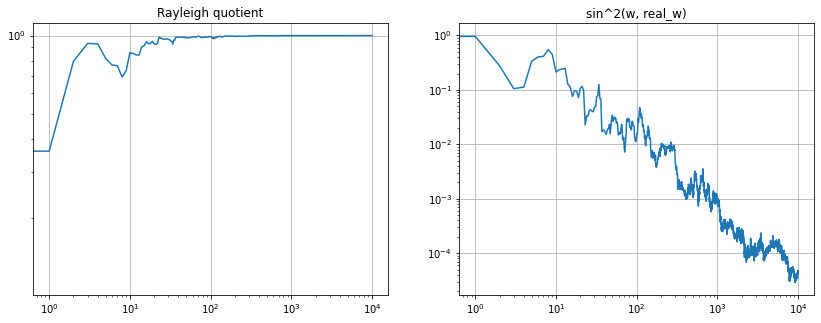

In [7]:
MAX_ITER = 10000

alpha,beta,gamma = 10,10,1.2

optimizer = AcSGD_with_decreasing_step(alpha, beta, gamma)
oja = Oja(test_case['d'], optimizer)
oja.run(test_case['A_stream'], max_iter=MAX_ITER)
oja.pretty_plot(test_case['A'])

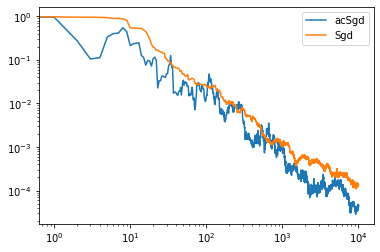

In [8]:
sgd = SGD_with_decreasing_step(lr=1, beta=1)
oja_sgd = Oja(test_case['d'], sgd)
oja_sgd.run(test_case['A_stream'], max_iter=MAX_ITER)

real_w = max_eigenvec(test_case['A']) 

loss_acSgd = oja.loss_history(real_w)
loss_sgd = oja_sgd.loss_history(real_w)
plt.loglog(loss_acSgd, label='acSgd')
plt.loglog(loss_sgd, label='Sgd')
plt.legend()

In [10]:
TRIALS = 20

def run_result(alpha, beta, gamma):
    dif = 0
    for i in range(TRIALS):
        oja = run_test_case(test_case, None, AcSGD_with_decreasing_step, {'alpha':alpha, 'beta':beta, 'gamma':gamma}, False)
        oja_sgd = run_test_case(test_case, None, SGD_with_decreasing_step, {'lr': 1, 'beta':1}, False)

        real_w = max_eigenvec(test_case['A']) 
        dif += np.mean(oja.loss_history(real_w)[-100:]) - np.mean(oja_sgd.loss_history(real_w)[-100:])

    return dif/TRIALS

In [16]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def objective(args):
    alpha = args['alpha']
    beta = args['beta']
    gamma = args['gamma']
    result = run_result(alpha, beta, gamma)
    return {
        'loss': result,
        'status': STATUS_OK
        }

space = {
    'alpha': hp.uniform('alpha', 0,10),
    'beta': hp.uniform('beta', 0,10),
    'gamma': hp.uniform('gamma', 0.1,2),
}

trials = Trials()
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)

print(best)

100%|██████████| 100/100 [1:20:26<00:00, 48.27s/trial, best loss: -0.06777367830324456] 
{'alpha': 7.664916419358874, 'beta': 4.943887874008745, 'gamma': 1.1797232190732982}


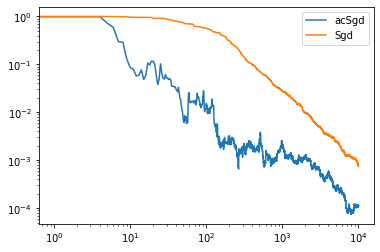

In [19]:
alpha,beta,gamma = best['alpha'], best['beta'], best['gamma']

optimizer = AcSGD_with_decreasing_step(alpha, beta, gamma)
oja = Oja(test_case['d'], optimizer)
oja.run(test_case['A_stream'], max_iter=MAX_ITER)

sgd = SGD_with_decreasing_step(lr=1, beta=1)
oja_sgd = Oja(test_case['d'], sgd)
oja_sgd.run(test_case['A_stream'], max_iter=MAX_ITER)

real_w = max_eigenvec(test_case['A']) 

loss_acSgd = oja.loss_history(real_w)
loss_sgd = oja_sgd.loss_history(real_w)
plt.loglog(loss_acSgd, label='acSgd')
plt.loglog(loss_sgd, label='Sgd')
plt.legend()